# NCI

In [54]:
import pandas as pd  
import numpy as np

from tdc.chem_utils import MolConvert
import sklearn.metrics.pairwise
from sklearn.metrics import pairwise_distances

import matplotlib.pyplot as plt

import nbimporter
from assistant import y_index, save, labels_to_tensor, vectorize_smile, drug_combi_index, data_indexed_combi, vectorize_drugcombi, tanimoto_similarity_matrix

## NCI Dataset 

In [9]:
# full data
full_data = pd.read_csv('./data/NCI-ALMANAC/NCI-ALMANAC_full_data.csv')
full_data

,Conc1,Conc2,Drug1,Drug2,CellLine,PercentageGrowth
0,0.000000e+00,1.000000e-03,Idarubicin hydrochloride,Streptozocin,786-0,86.842
1,0.000000e+00,1.000000e-03,4'-Epiadriamycin,Streptozocin,786-0,86.842
2,0.000000e+00,1.000000e-04,Azacitidine,Dexrazoxane,786-0,72.371
3,0.000000e+00,1.000000e-04,Azacitidine,Fluorouracil,786-0,36.165
4,0.000000e+00,1.000000e-04,Azacitidine,Chlorambucil,786-0,44.122
...,...,...,...,...,...,...
4944595,8.000000e-09,5.000000e-09,Nilotinib,Cabazitaxel,SK-MEL-28,42.582
4944596,8.000000e-09,5.000000e-10,Nilotinib,Cabazitaxel,SK-MEL-28,70.324
4944597,8.000000e-09,7.500000e-05,Nilotinib,Altretamine,SK-MEL-28,89.767
4944598,8.000000e-09,7.500000e-06,Nilotinib,Altretamine,SK-MEL-28,104.690


### Preprocessing 

In [10]:
# filter out the datasets where PercentageGrowth == NaN 
data = full_data.drop(full_data[full_data.PercentageGrowth.isna()].index)

# drug name "Pemetrexed Disodium " --> "Pemetrexed Disodium" removed space
data.loc[data.Drug1 == "Pemetrexed Disodium ", "Drug1"] = "Pemetrexed Disodium"

### Indexing Dataset

In [19]:
# given drug information with SMILES string
drug = pd.read_csv("./data/NCI-ALMANAC/additional_data/drugs__SMILES.csv")

In [20]:
# index drug (that is also applicablie for morgan fingerprint)
drug_idx = drug.drop(drug[drug.Drug == "Cisplatin"].index).reset_index(drop=True)   # 'Cisplatin' = [H][N]([H])([H])[Pt](Cl)(Cl)[N]([H])([H])[H] is not able to be converted to morgan fingerprint
drug_idx["Drug_Index"] = drug_idx.index

# index CellLine 
distinct_cellLine = set(data.CellLine)
cellLine_idx = y_index(distinct_cellLine, "CellLine")

In [22]:
# index the whole dataset
data_indexed = data.merge(drug_idx, left_on='Drug1', right_on='Drug').rename(columns={"Drug_Index":"Drug1_Index"})
data_indexed = data_indexed.merge(drug_idx, left_on='Drug2', right_on='Drug').rename(columns={"Drug_Index":"Drug2_Index"})
data_indexed = data_indexed.merge(cellLine_idx) 

In [24]:
# reconstruct the dataset by averaging the PercentageGrowth 
data_avg = data_indexed.groupby(['Drug1_Index', 'Drug2_Index', 'CellLine_Index']).agg({'PercentageGrowth': 'mean'})
data_avg = data_avg.reset_index()

(array([4.0000e+00, 3.0000e+00, 9.0000e+00, 2.0000e+01, 4.2000e+01,
        5.2000e+01, 7.0000e+01, 1.0500e+02, 1.4000e+02, 2.3000e+02,
        2.3500e+02, 3.0400e+02, 3.2900e+02, 4.1800e+02, 6.1100e+02,
        8.4900e+02, 8.2800e+02, 1.0410e+03, 1.2510e+03, 1.8460e+03,
        2.5140e+03, 3.4950e+03, 4.7030e+03, 6.1440e+03, 8.3600e+03,
        1.0514e+04, 1.2406e+04, 1.4435e+04, 1.6872e+04, 2.0579e+04,
        2.4338e+04, 2.6089e+04, 2.8414e+04, 3.2686e+04, 3.9475e+04,
        3.0695e+04, 1.1075e+04, 2.8880e+03, 8.9600e+02, 3.2900e+02,
        1.5400e+02, 7.1000e+01, 2.8000e+01, 2.2000e+01, 5.0000e+00,
        5.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 2.0000e+00]),
 array([-82.85   , -77.64876, -72.44752, -67.24628, -62.04504, -56.8438 ,
        -51.64256, -46.44132, -41.24008, -36.03884, -30.8376 , -25.63636,
        -20.43512, -15.23388, -10.03264,  -4.8314 ,   0.36984,   5.57108,
         10.77232,  15.97356,  21.1748 ,  26.37604,  31.57728,  36.77852,
         41.97976,  47

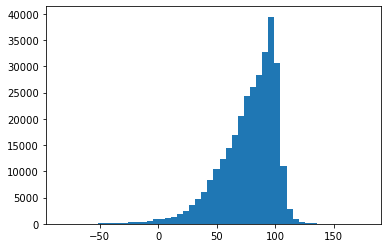

In [25]:
plt.hist(data_avg.PercentageGrowth, bins=50)

In [26]:
data_avg_thres = data_avg[abs(data_avg.PercentageGrowth) >= 100]  # --> 100 

## Labels

In [37]:
# labels quadruplets [Drug1, Drug2, CellLine, PercentageGrowth]
labels_quadruplet = np.array(data_avg_thres[['Drug1_Index', 'Drug2_Index', 'CellLine_Index',"PercentageGrowth"]]).astype(int)
labels_quadruplet = labels_quadruplet[labels_quadruplet[:,0] != labels_quadruplet[:,1]]

In [39]:
# label tensor (Yabc)
labels_tensor = labels_to_tensor(labels_quadruplet, drug_idx, cellLine_idx)

In [ ]:
# save(labels_quadruplet, "../Final_DF/NCI_Label_filtered.txt")
# labels_quadruplet = np.loadtxt("../Final_DF/NCI_Label_filtered.txt") 

## Feature Vectorizatoin

### Drug
[1] SMILES

In [43]:
# vectorize with one-hot coding of SMILES string
drug_vectorized_smile = vectorize_smile(drug_idx.SMILE)  # (103, 260, 35)

# reshape into 2D dimension   
drug_vectorized_smile = drug_vectorized_smile.reshape(drug_vectorized_smile.shape[0], drug_vectorized_smile.shape[1] * drug_vectorized_smile.shape[2])  # (103, 9100)

[2] Morgan fingerprint 

The molecule conversion API of TDC is applied.

In [46]:
# convert SMILES string into morgan fingerprint with 1024 features 
converter = MolConvert(src = 'SMILES', dst = 'Morgan')
drug_vectorized_morgan = converter(drug_idx.SMILE.values.tolist()).astype("int8")  # (103, 1024)

### Cancer Cell Line

In [49]:
# index drug-drug combination
combi_idx = drug_combi_index(drug_idx)   # (5253, 3)

# merge into the data_indexed
data_indexed_combi = data_indexed_combi(data_avg_thres, combi_idx)
labels_triplets_drugcombi = np.array(data_indexed_combi[['Drug1_Index', 'Drug2_Index', 'CellLine_Index', "Combi_Index"]]).astype(int)

In [52]:
# vectorize into 2D tensor of data_indexed 
cellLine_vectorized = vectorize_drugcombi(labels_triplets_drugcombi, combi_idx, cellLine_idx)

## Similarity Kernels

### Drug
[1] SMILES

In [ ]:
# cosine similarity 
K_drug_smile_cos = sklearn.metrics.pairwise.cosine_similarity(drug_vectorized_smile)

In [ ]:
# tanimoto similarity
K_drug_smile_tanimoto = tanimoto_similarity_matrix(drug_vectorized_smile)

[2] Morgan fingerprint

In [ ]:
# cosine similarity 
K_drug_morgan_cos = sklearn.metrics.pairwise.cosine_similarity(drug_vectorized_morgan)

In [ ]:
# tanimoto similarity
K_drug_morgan_tanimoto = tanimoto_similarity_matrix(drug_vectorized_morgan)

### Cancer cell line

In [ ]:
# cosine similarity 
K_CellLine_cos = sklearn.metrics.pairwise.cosine_similarity(cellLine_vectorized)

In [ ]:
# jaccard similarity
K_CellLine_jacc = 1 - sklearn.metrics.pairwise_distances(cellLine_vectorized, metric ='jaccard')   

In [ ]:
# save(K_drug_smile_cos, "../Final_DF/NCI_drug_smile_cos.txt")
# save(K_drug_smile_tanimoto, "../Final_DF/NCI_drug_smile_tanimoto.txt")
# save(K_drug_morgan_cos, "../Final_DF/NCI_drug_morgan_cos.txt")
# save(K_drug_morgan_tanimoto, "../Final_DF/NCI_drug_morgana_tanimoto.txt")
# save(K_CellLine_cos, "../Final_DF/NCI_CellLine_cos.txt")
# save(K_CellLine_jacc, "../Final_DF/NCI_CellLine_jacc.txt")

### Further Experiments
We adjusted the imbalanced class ratio to study the influence of it.

In [ ]:
# corresponding to TDC label ratio 1.7 %
data_avg_thres_tdc = data_avg[abs(data_avg.PercentageGrowth) >= 108.8]  # 5363 

# corresponding to DCDB label ratio 0.0018 %
data_avg_thres_dcdb = data_avg[abs(data_avg.PercentageGrowth) >= 156] # 6 

# corresponding to 1%, 2% 5%, 10% 
data_avg_thres_1 = data_avg[abs(data_avg.PercentageGrowth) >=111]  # 3247
data_avg_thres_2 = data_avg[abs(data_avg.PercentageGrowth) >=108.2]  # 6227
data_avg_thres_5 = data_avg[abs(data_avg.PercentageGrowth) >=104.4]  # 15461
data_avg_thres_10 = data_avg[abs(data_avg.PercentageGrowth) >=101.57]  # 29388

In [ ]:
labels_quadruplet_tdc = np.array(data_avg_thres2[['Drug1_Index', 'Drug2_Index', 'CellLine_Index',"PercentageGrowth"]]).astype(int)
labels_quadruplet_dcdb = np.array(data_avg_thres3[['Drug1_Index', 'Drug2_Index', 'CellLine_Index',"PercentageGrowth"]]).astype(int)

labels_quadruplet_1 = np.array(data_avg_thres_1[['Drug1_Index', 'Drug2_Index', 'CellLine_Index',"PercentageGrowth"]]).astype(int)
labels_quadruplet_2 = np.array(data_avg_thres_2[['Drug1_Index', 'Drug2_Index', 'CellLine_Index',"PercentageGrowth"]]).astype(int)
labels_quadruplet_5 = np.array(data_avg_thres_5[['Drug1_Index', 'Drug2_Index', 'CellLine_Index',"PercentageGrowth"]]).astype(int)
labels_quadruplet_10 = np.array(data_avg_thres_10[['Drug1_Index', 'Drug2_Index', 'CellLine_Index',"PercentageGrowth"]]).astype(int)

In [ ]:
labels_quadruplet_tdc = labels_quadruplet2[labels_quadruplet2[:,0] != labels_quadruplet2[:,1]]
labels_quadruplet_dcdb = labels_quadruplet3[labels_quadruplet3[:,0] != labels_quadruplet3[:,1]]

labels_quadruplet_1 = labels_quadruplet_1[labels_quadruplet_1[:,0] != labels_quadruplet_1[:,1]]
labels_quadruplet_2 = labels_quadruplet_2[labels_quadruplet_2[:,0] != labels_quadruplet_2[:,1]]
labels_quadruplet_5 = labels_quadruplet_5[labels_quadruplet_5[:,0] != labels_quadruplet_5[:,1]]
labels_quadruplet_10 = labels_quadruplet_10[labels_quadruplet_10[:,0] != labels_quadruplet_10[:,1]]

In [ ]:
# save(labels_quadruplet_tdc, "../Final_DF/NCI_Label_filtered_tdc.txt")
# save(labels_quadruplet_dcdb, "../Final_DF/NCI_Label_filtered_dcdb.txt")

# save(labels_quadruplet_1, "../Final_DF/NCI_Label_filtered_1.txt")
# save(labels_quadruplet_2, "../Final_DF/NCI_Label_filtered_2.txt")
# save(labels_quadruplet_5, "../Final_DF/NCI_Label_filtered_5.txt")
# save(labels_quadruplet_10, "../Final_DF/NCI_Label_filtered_10.txt")